In [1]:
# Import dependencies
%matplotlib inline
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import anndata
import matplotlib.pyplot as plt
import yaml
import scvi
import ray
import hyperopt
from ray import tune
from scvi import autotune

# Print date and time:
import datetime
e = datetime.datetime.now()
print ("Current date and time = %s" % e)

# Set other settings
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packag

Current date and time = 2024-08-30 13:10:33.454896
-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                         9.4.0
absl                        NA
aiohttp                     3.9.5
aiosignal                   1.3.1
annotated_types             0.5.0
anyio                       NA
arrow                       1.2.3
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.14.0
backcall                    0.2.0
backoff                     2.2.1
brotli                      NA
bs4                         4.12.2
certifi                     2024.07.04
cffi                        1.15.1
charset_normalizer          3.2.0
chex                        0.1.83
click                       8.1.5
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.1.3
contextlib2                 NA
croniter                    NA
cycler                  

In [2]:
# set a working directory
wdir = '/media/prom/apc1/ccohen/chromium/analysis/20240711_Achilles'
os.chdir( wdir )

# create an output directory with today's date and time
year = e.strftime("%Y")
month = e.strftime("%m")
day = e.strftime("%d")
hour = e.strftime('%H')
minute = e.strftime('%M')
dmyt = f'{year}{month}{day}_{hour}-{minute}'
directory = f'{dmyt}_integration-scvi.dir'

# folder structures
RESULTS_FOLDERNAME = f'{directory}/results/'
FIGURES_FOLDERNAME = f'{directory}/figures/'

if not os.path.exists(RESULTS_FOLDERNAME):
    os.makedirs(RESULTS_FOLDERNAME)
if not os.path.exists(FIGURES_FOLDERNAME):
    os.makedirs(FIGURES_FOLDERNAME)
    
# Set folder for saving figures into
sc.settings.figdir = FIGURES_FOLDERNAME

print(directory)

20240830_13-10_integration-scvi.dir


In [3]:
# read in the concatenated and normalised dataset
adata = sc.read_h5ad('20240829_14-04_concat_norm.dir/results/merged_normalised.h5ad')
adata

AnnData object with n_obs × n_vars = 69476 × 61552
    obs: 'sample', 'sum', 'detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'sizeFactor', 'scDblFinder.class', 'patient.seqbatch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'microanatomical_site_colors', 'neighbors', 'patient_colors', 'pca', 'sample_colors', 'sequencing_date_colors', 'sex_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'decontX', 'log1p_norm', 'scaled', 'soupX'
    obsp: 'connectivities', 'distances'

In [18]:
# subset to decontX <0.3
adata = adata[adata.obs['decontX_contamination'] < 0.3,:].copy()
adata

AnnData object with n_obs × n_vars = 67668 × 61552
    obs: 'sample', 'sum', 'detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'sizeFactor', 'scDblFinder.class', 'patient.seqbatch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'microanatomical_site_colors', 'neighbors', 'patient_colors', 'pca', 'sample_colors', 'sequencing_date_colors', 'sex_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'decontX', 'log1p_norm', 'scaled', 'soupX'
    obsp: 'connectivities', 'distances'

In [5]:
# read in the scVI embeddings
scVI_embeddings = np.load('20240830_11-05_integration-scvi.dir/results/scVI_embeddings.npy')
scVI_embeddings

array([[ 0.2020717 ,  0.00223327,  0.5529001 , ...,  0.96067053,
        -1.2254053 ,  0.8594356 ],
       [-0.19805932,  0.55582964,  1.0374081 , ..., -0.54789746,
         0.9428748 , -0.08063512],
       [ 0.8624213 , -0.19135177,  0.8911075 , ..., -0.5220918 ,
         1.7805381 ,  0.26943645],
       ...,
       [-0.51051253, -0.44119895, -1.3921677 , ..., -0.93948233,
        -1.2892416 , -0.46166146],
       [-1.8942188 ,  0.04300606, -0.8040659 , ...,  0.2447783 ,
        -0.2032091 , -0.54780143],
       [-1.399494  , -0.42244387,  0.8249756 , ...,  0.4765728 ,
        -0.44955218, -0.877786  ]], dtype=float32)

In [17]:
print(scVI_embeddings.shape)
print(adata.obsm['X_pca'].shape)

(67668, 50)
(69476, 40)


In [20]:
# add the scVI embeddings to the adata object as a new obsm
adata.obsm['X_scVI'] = scVI_embeddings
adata

AnnData object with n_obs × n_vars = 67668 × 61552
    obs: 'sample', 'sum', 'detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'sizeFactor', 'scDblFinder.class', 'patient.seqbatch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'microanatomical_site_colors', 'neighbors', 'patient_colors', 'pca', 'sample_colors', 'sequencing_date_colors', 'sex_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'decontX', 'log1p_norm', 'scaled', 'soupX'
    obsp: 'connectivities', 'distances'

In [21]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

computing neighbors


/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/media/prom/apc1

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


NameError: name 'adata_scvi' is not defined

In [22]:
sc.tl.leiden(adata, key_added="leiden_res0_1", resolution=0.1)
sc.tl.leiden(adata, key_added="leiden_res0_2", resolution=0.2)
sc.tl.leiden(adata, key_added="leiden_res0_3", resolution=0.3)

running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res0_1', the cluster labels (adata.obs, categorical) (0:00:04)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_res0_2', the cluster labels (adata.obs, categorical) (0:00:05)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_res0_3', the cluster labels (adata.obs, categorical) (0:00:06)


/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the 

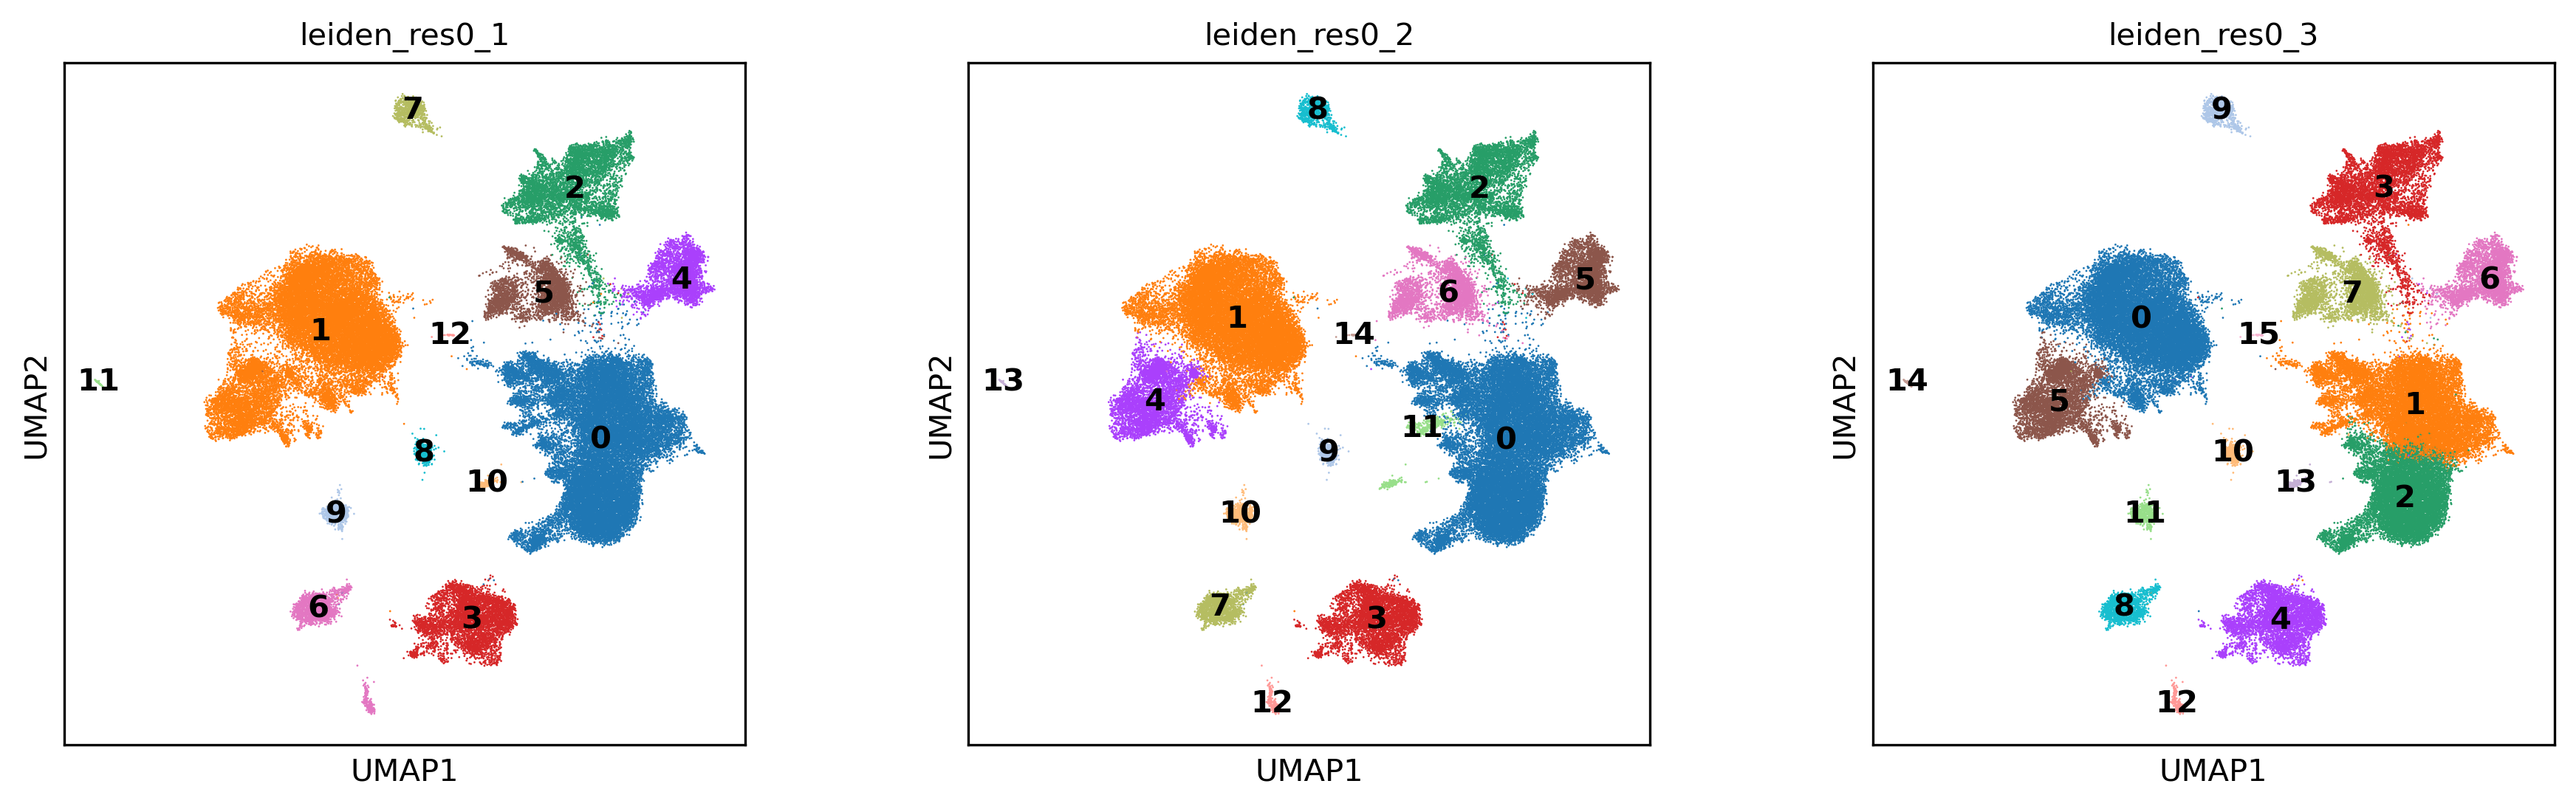

In [23]:
sc.pl.umap(
    adata,
    color=["leiden_res0_1", "leiden_res0_2", "leiden_res0_3"],
    legend_loc="on data",
)

In [24]:
# set adata.X to the soupX corrected counts
adata.X = adata.layers['soupX']

In [31]:
marker_genes = {
    "Fibroblasts": ["COL1A1", "COL1A2", "COL3A1", "DCN"],
    "Muscle": ["TRDN", "TTN", "NEB"],
    "Slow-twitch": ["TNNT1", "LGR5", "ATP2A2"],
    "Fasttwitch": ["TNNT3", "MYH1", "MYH3"], 
    "Transitional muscle": ["COL22A1", "SPAG16", "SORBS2"],
    "Satellite cells": ["PAX7", "CALCR", "CDH4", "CLCN5"],
    "Mural": ["NOTCH3", "PDGFRB", "MYO1B"], 
    "LECT": ["MMRN1", "PROX1", "PKHD1L1"],
    "VEC": ["PECAM1", "PTPRB", "FLT1", "VWF"], 
    "Adipocytes": ["PLIN1", "AQP7", "ADIPOQ"], 
    "Macrophages": ["F13A1", "CD163", "MRC1"],
    "T cells": ["CD247", "IL7R", "THEMIS"], 
    "Granulocytes": ["KIT", "CPA3", "IL18R1", "CDK15"], 
    "B cells": ["BLNK", "CLNK","IGHM", "IL4R"],  
    "Nervous system": ["NRXN1", "XKR4", "CDH19", "PPP2R2B"]
}

In [34]:
# subset to marker genes that are detected in the adata object
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

In [36]:
marker_genes_in_data

{'Fibroblasts': ['COL1A1', 'COL1A2', 'COL3A1', 'DCN'],
 'Muscle': ['TRDN', 'TTN', 'NEB'],
 'Slow-twitch': ['TNNT1', 'LGR5', 'ATP2A2'],
 'Fasttwitch': ['TNNT3', 'MYH1', 'MYH3'],
 'Transitional muscle': ['COL22A1', 'SPAG16', 'SORBS2'],
 'Satellite cells': ['PAX7', 'CALCR', 'CDH4', 'CLCN5'],
 'Mural': ['NOTCH3', 'PDGFRB', 'MYO1B'],
 'LECT': ['MMRN1', 'PROX1', 'PKHD1L1'],
 'VEC': ['PECAM1', 'PTPRB', 'FLT1', 'VWF'],
 'Adipocytes': ['PLIN1', 'AQP7', 'ADIPOQ'],
 'Macrophages': ['F13A1', 'CD163', 'MRC1'],
 'T cells': ['CD247', 'IL7R', 'THEMIS'],
 'Granulocytes': ['KIT', 'CPA3', 'IL18R1', 'CDK15'],
 'B cells': ['BLNK', 'CLNK', 'IGHM', 'IL4R'],
 'Nervous system': ['NRXN1', 'XKR4', 'CDH19', 'PPP2R2B']}

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colorm

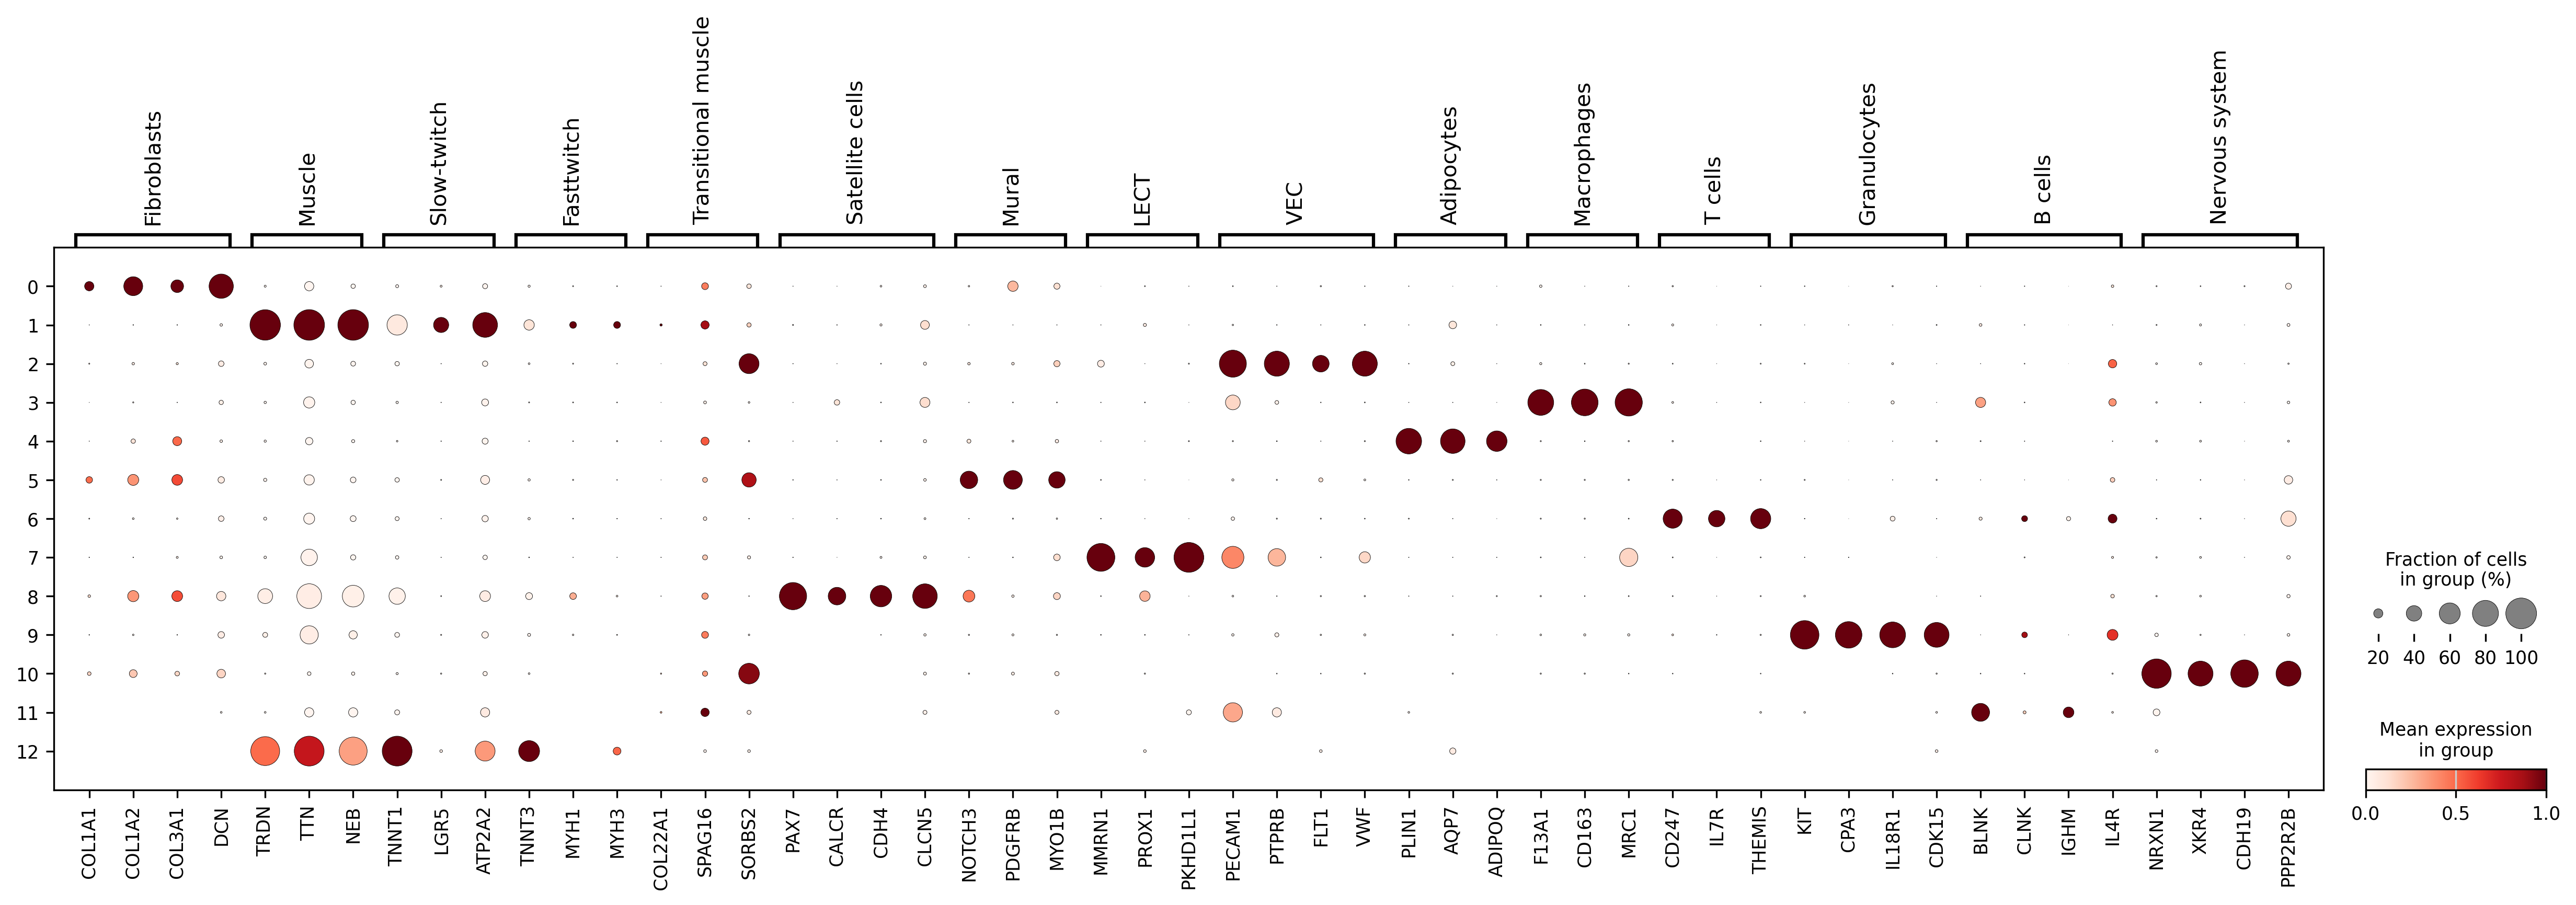

In [37]:
sc.pl.dotplot(
    adata,
    groupby="leiden_res0_1",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [43]:
adata.uns['log1p']["base"] = None # add this to fix an error runing rank_genes_groups below

In [45]:
# calculate top cluster-specific genes
# this has to be run on the log normalised data, soupX does not work
sc.tl.rank_genes_groups(adata, groupby="leiden_res0_1", method="wilcoxon", layer = "log1p_norm")

ranking genes


/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:46)


In [46]:
adata

AnnData object with n_obs × n_vars = 67668 × 61552
    obs: 'sample', 'sum', 'detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'sizeFactor', 'scDblFinder.class', 'patient.seqbatch', 'leiden_res0_1', 'leiden_res0_2', 'leiden_res0_3'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'microanatomical_site_colors', 'neighbors', 'patient_colors', 'pca', 'sample_colors', 'sequencing_date_colors', 'sex_colors', 'umap', 'leiden', 'leiden_res0_1_colors', 'leiden_res0_2_colors', 'leiden_res0_3_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'decontX', 'log1p_norm', 'scaled', 'soupX'
    obsp: 'connect

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will 

    using 'X_pca' with n_pcs = 40
Storing dendrogram info using `.uns['dendrogram_leiden_res0_1']`


/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of o

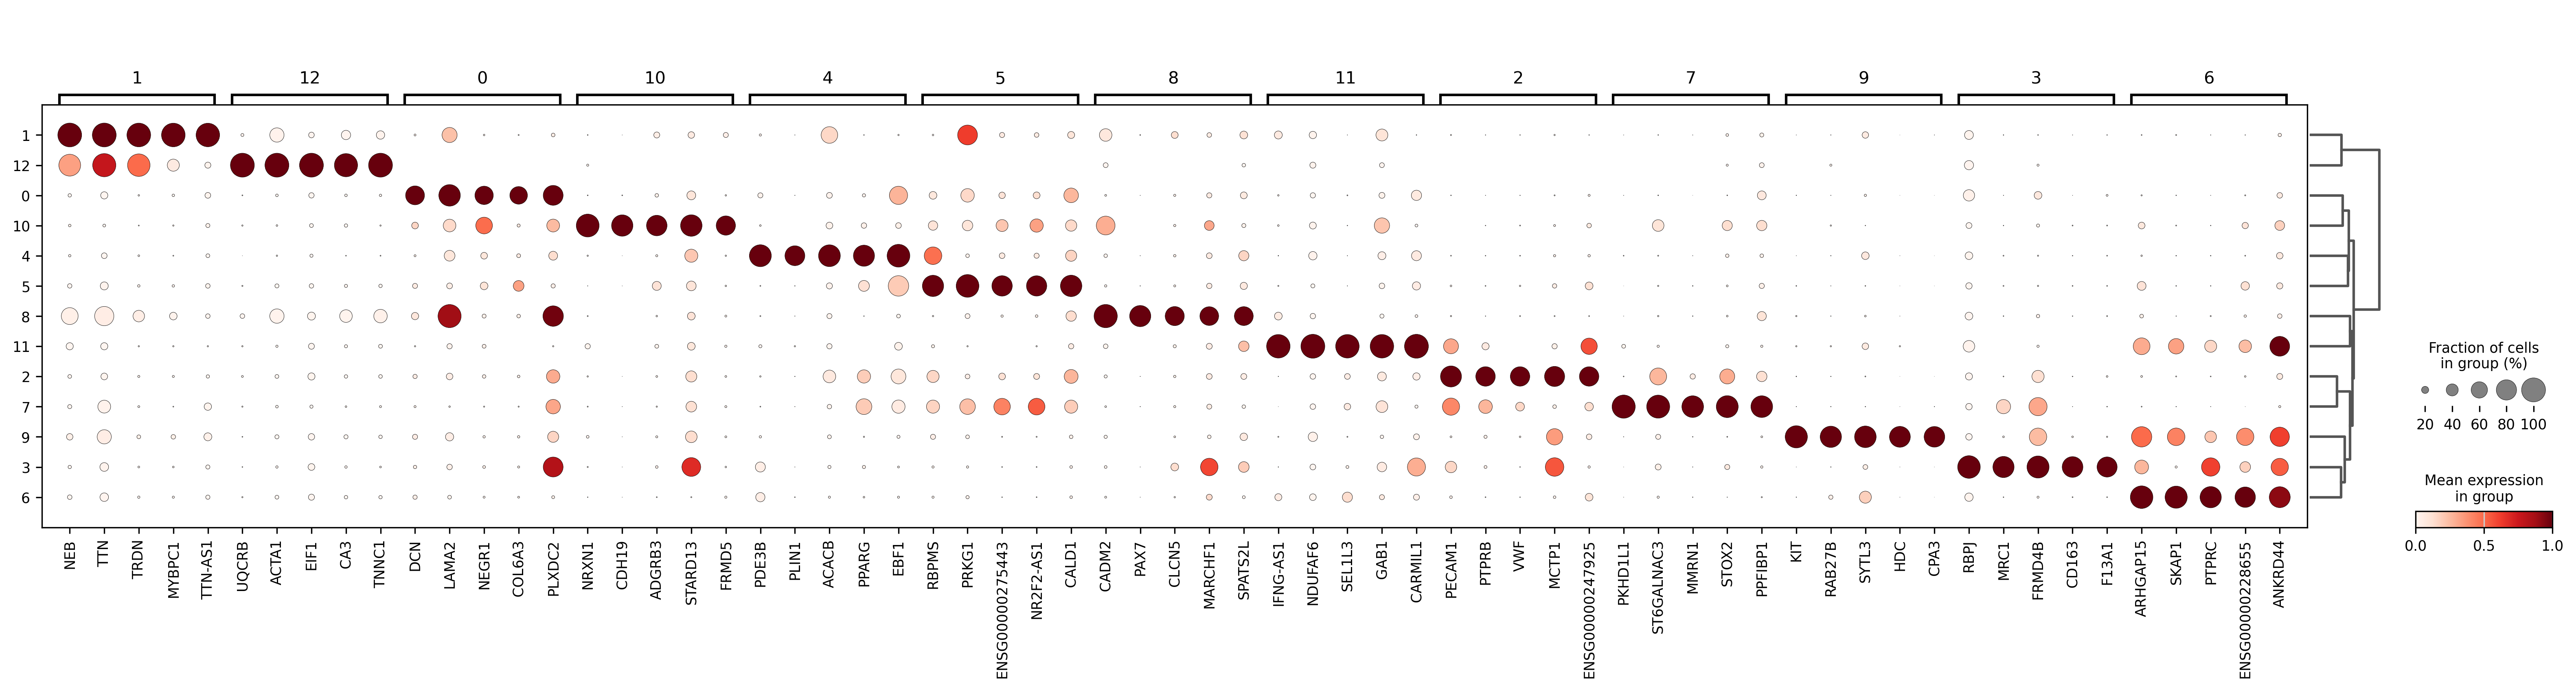

In [47]:
# dotplot of cluster-specific genes
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res0_1", standard_scale="var", n_genes=5
)

In [50]:
adata.uns['rank_genes_groups']

{'params': {'groupby': 'leiden_res0_1',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': 'log1p_norm',
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('DCN', 'NEB', 'PECAM1', 'RBPJ', 'PDE3B', 'RBPMS', 'ARHGAP15', 'PKHD1L1', 'CADM2', 'KIT', 'NRXN1', 'IFNG-AS1', 'UQCRB'),
            ('LAMA2', 'TTN', 'PTPRB', 'MRC1', 'PLIN1', 'PRKG1', 'SKAP1', 'ST6GALNAC3', 'PAX7', 'RAB27B', 'CDH19', 'NDUFAF6', 'ACTA1'),
            ('NEGR1', 'TRDN', 'VWF', 'FRMD4B', 'ACACB', 'ENSG00000275443', 'PTPRC', 'MMRN1', 'CLCN5', 'SYTL3', 'ADGRB3', 'SEL1L3', 'EIF1'),
            ...,
            ('NEB', 'UTRN', 'RORA', 'ENSG00000256947', 'C1orf21', 'FOXO1', 'DST', 'MALAT1', 'PTPRM', 'ZBTB16', 'SVIL', 'ENSG00000256947', 'ZBTB20'),
            ('DMD', 'TACC1', 'DMD', 'PARD3', 'AKAP13', 'ADCY2', 'ZBTB16', 'LAMA2', 'NEAT1', 'PTPRG', 'MALAT1', 'MBNL1', 'NEAT1'),
            ('TTN', 'SOX5', 'ADCY2', 'RORA', 'PDE4D', 'LAMA2', 'NEAT1', 'FKBP5', 'MBNL1', 'RORA', 'NEAT1', 'ZBTB16'

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will 

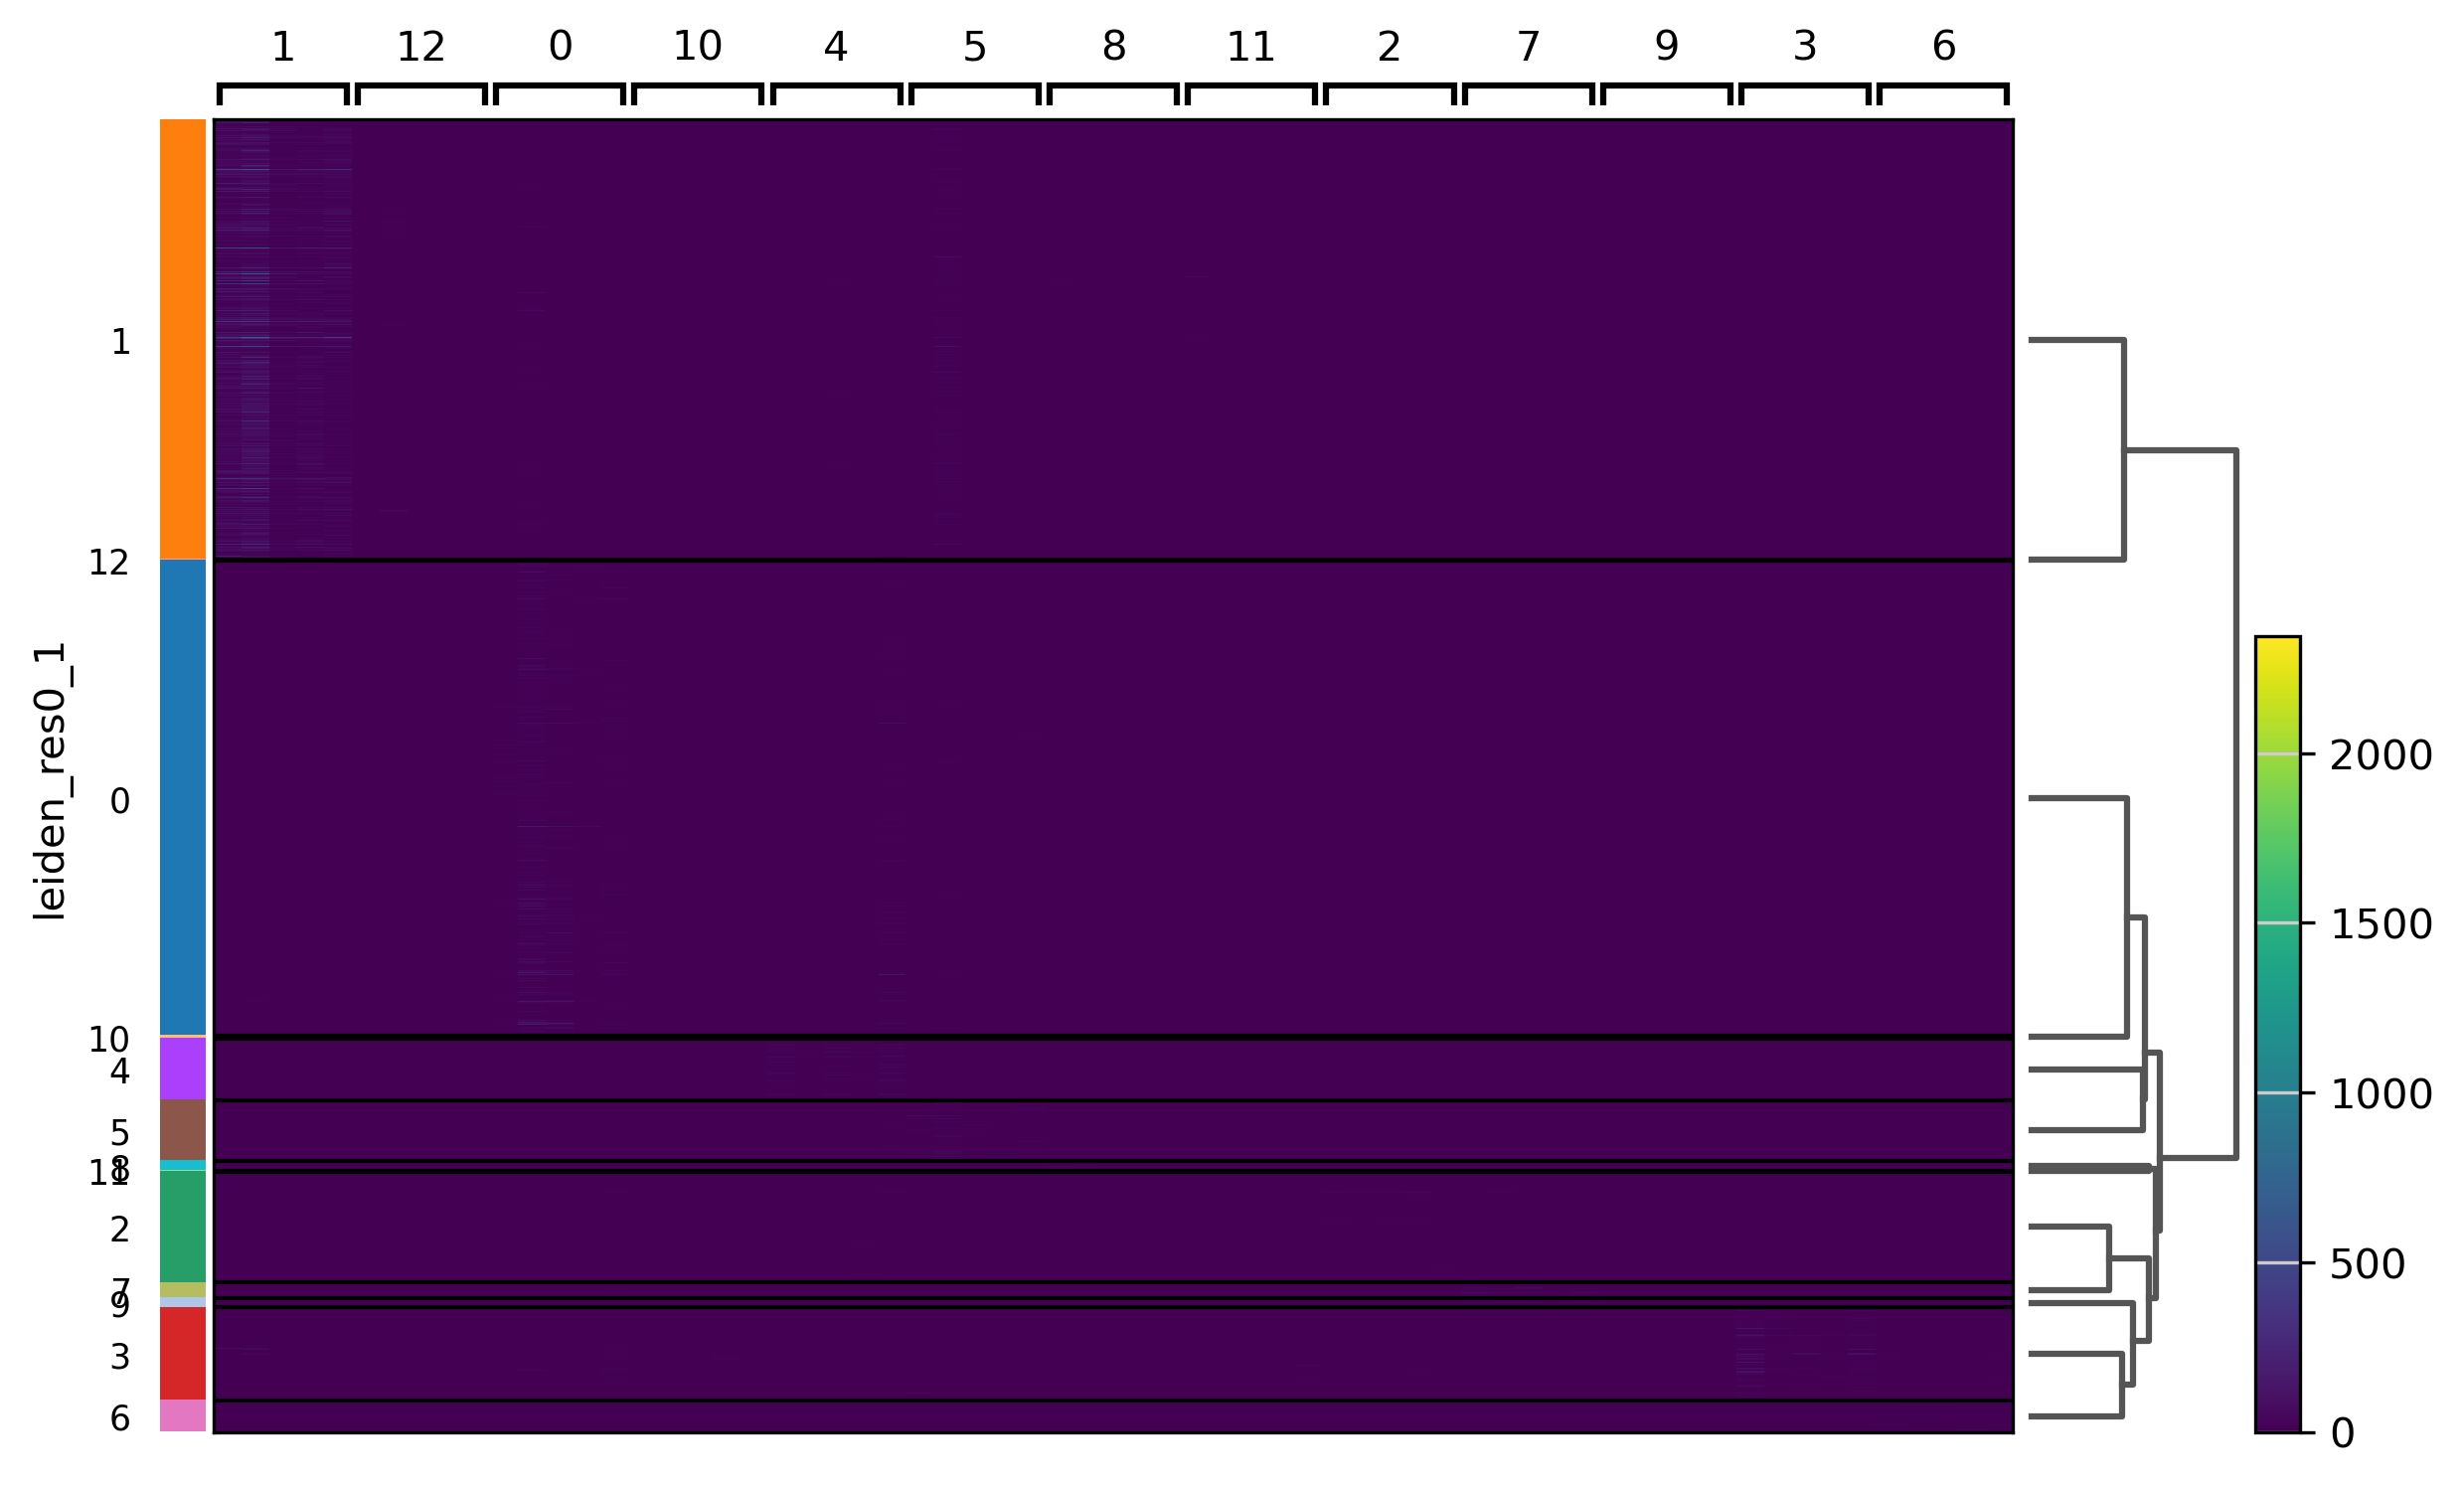

In [53]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5)